<a href="https://colab.research.google.com/github/smsultan76/MachineLearning/blob/main/customer_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Setting plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*50)
print("CUSTOMER CLUSTERING ANALYSIS")
print("="*50)

CUSTOMER CLUSTERING ANALYSIS


In [2]:
# Load data
df = pd.read_csv('/content/shopping_behavior_updated.csv')
df_original = df.copy()  # Create copy of original data
print(f"Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Data loaded successfully!
Shape: (3900, 18)
Columns: ['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Payment Method', 'Frequency of Purchases']


In [3]:
print("\n1. DATA PREPROCESSING")
print("-" * 30)

# Create age groups for better segmentation
df['Age_Group'] = pd.cut(df['Age'],
                        bins=[0, 25, 35, 45, 55, 65, 100],
                        labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Feature engineering
print("Creating additional features...")

# Customer value segments based on purchase amount and frequency
df['Customer_Value'] = df['Purchase Amount (USD)'] * df['Previous Purchases']

# Create behavioral segments
df['High_Value_Customer'] = (df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].quantile(0.75)).astype(int)
df['Frequent_Buyer'] = (df['Previous Purchases'] > df['Previous Purchases'].quantile(0.75)).astype(int)
df['High_Rating_Customer'] = (df['Review Rating'] > 4.0).astype(int)

# Select features for clustering
clustering_features = [
    'Age',
    'Purchase Amount (USD)',
    'Review Rating',
    'Previous Purchases',
    'High_Value_Customer',
    'Frequent_Buyer',
    'High_Rating_Customer'
]

# Prepare numerical features
X_numerical = df[clustering_features].copy()

print(f"Selected features for clustering: {clustering_features}")
print(f"Shape of clustering dataset: {X_numerical.shape}")


1. DATA PREPROCESSING
------------------------------
Creating additional features...
Selected features for clustering: ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'High_Value_Customer', 'Frequent_Buyer', 'High_Rating_Customer']
Shape of clustering dataset: (3900, 7)


In [4]:
# Handle categorical variables using Label Encoding for additional features
categorical_features = ['Gender', 'Category', 'Season', 'Payment Method', 'Frequency of Purchases']

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature + '_encoded'] = le.fit_transform(df[feature])
    label_encoders[feature] = le
    clustering_features.append(feature + '_encoded')
    X_numerical[feature + '_encoded'] = df[feature + '_encoded']

print(f"Total features after encoding: {len(clustering_features)}")

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

print("Data preprocessing completed!")

Total features after encoding: 12
Data preprocessing completed!


In [5]:
print("\n2. FINDING OPTIMAL NUMBER OF CLUSTERS")
print("-" * 30)

# Elbow method and Silhouette analysis
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    # Silhouette score
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}: WCSS = {kmeans.inertia_:.2f}, Silhouette = {silhouette_avg:.3f}")


2. FINDING OPTIMAL NUMBER OF CLUSTERS
------------------------------
K=2: WCSS = 40156.00, Silhouette = 0.149
K=3: WCSS = 35653.05, Silhouette = 0.157
K=4: WCSS = 32327.63, Silhouette = 0.155
K=5: WCSS = 30730.73, Silhouette = 0.168
K=6: WCSS = 29292.98, Silhouette = 0.144
K=7: WCSS = 28107.40, Silhouette = 0.152
K=8: WCSS = 27360.05, Silhouette = 0.130
K=9: WCSS = 26275.32, Silhouette = 0.142
K=10: WCSS = 25858.99, Silhouette = 0.139


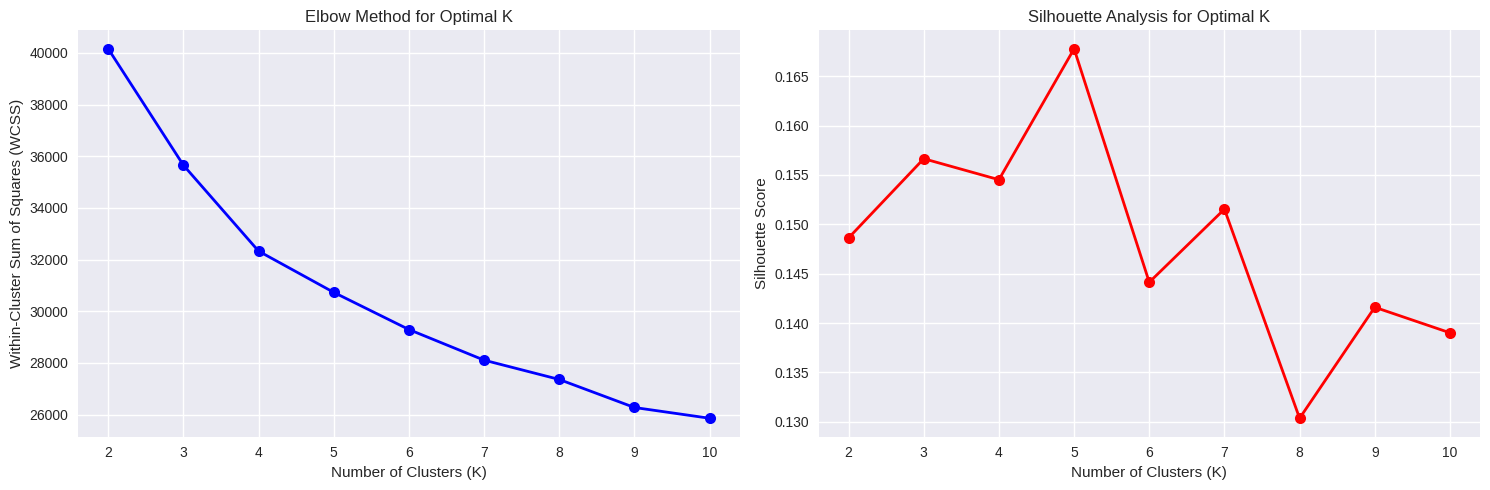


Selected optimal number of clusters: 4


In [6]:
# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal K')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal K (you can adjust this based on the plots)
optimal_k = 4  # This can be changed based on elbow and silhouette analysis
print(f"\nSelected optimal number of clusters: {optimal_k}")

In [7]:
print("\n3. K-MEANS CLUSTERING")
print("-" * 30)

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['Cluster'] = clusters
X_numerical['Cluster'] = clusters

print("K-means clustering completed!")
print(f"Cluster distribution:")
print(df['Cluster'].value_counts().sort_index())


3. K-MEANS CLUSTERING
------------------------------
K-means clustering completed!
Cluster distribution:
Cluster
0     697
1     848
2    1427
3     928
Name: count, dtype: int64


In [9]:
print("\n4. CLUSTER PROFILING")
print("-" * 30)

# Calculate cluster statistics
cluster_profile = df.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Purchase Amount (USD)': ['mean', 'std'],
    'Review Rating': ['mean', 'std'],
    'Previous Purchases': ['mean', 'std'],
    'Gender': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Frequency of Purchases': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Customer ID': 'count'
}).round(2)

cluster_profile.columns = ['Age_Mean', 'Age_Std', 'Purchase_Mean', 'Purchase_Std',
                          'Rating_Mean', 'Rating_Std', 'PrevPurchases_Mean', 'PrevPurchases_Std',
                          'Dominant_Gender', 'Dominant_Category', 'Dominant_Frequency', 'Count']

print("Cluster Profile Summary:")
print(cluster_profile)


4. CLUSTER PROFILING
------------------------------
Cluster Profile Summary:
         Age_Mean  Age_Std  Purchase_Mean  Purchase_Std  Rating_Mean  \
Cluster                                                                
0           43.86    15.23          91.07          5.45         3.77   
1           43.39    15.62          50.45         18.38         4.52   
2           44.20    15.12          49.87         17.79         3.27   
3           44.64    14.95          59.98         23.97         3.77   

         Rating_Std  PrevPurchases_Mean  PrevPurchases_Std Dominant_Gender  \
Cluster                                                                      
0              0.73               19.10              11.09            Male   
1              0.27               19.53              11.07            Male   
2              0.45               19.42              10.84            Male   
3              0.70               44.48               3.45            Male   

        Dominant_Cat


5. CLUSTER VISUALIZATION
------------------------------


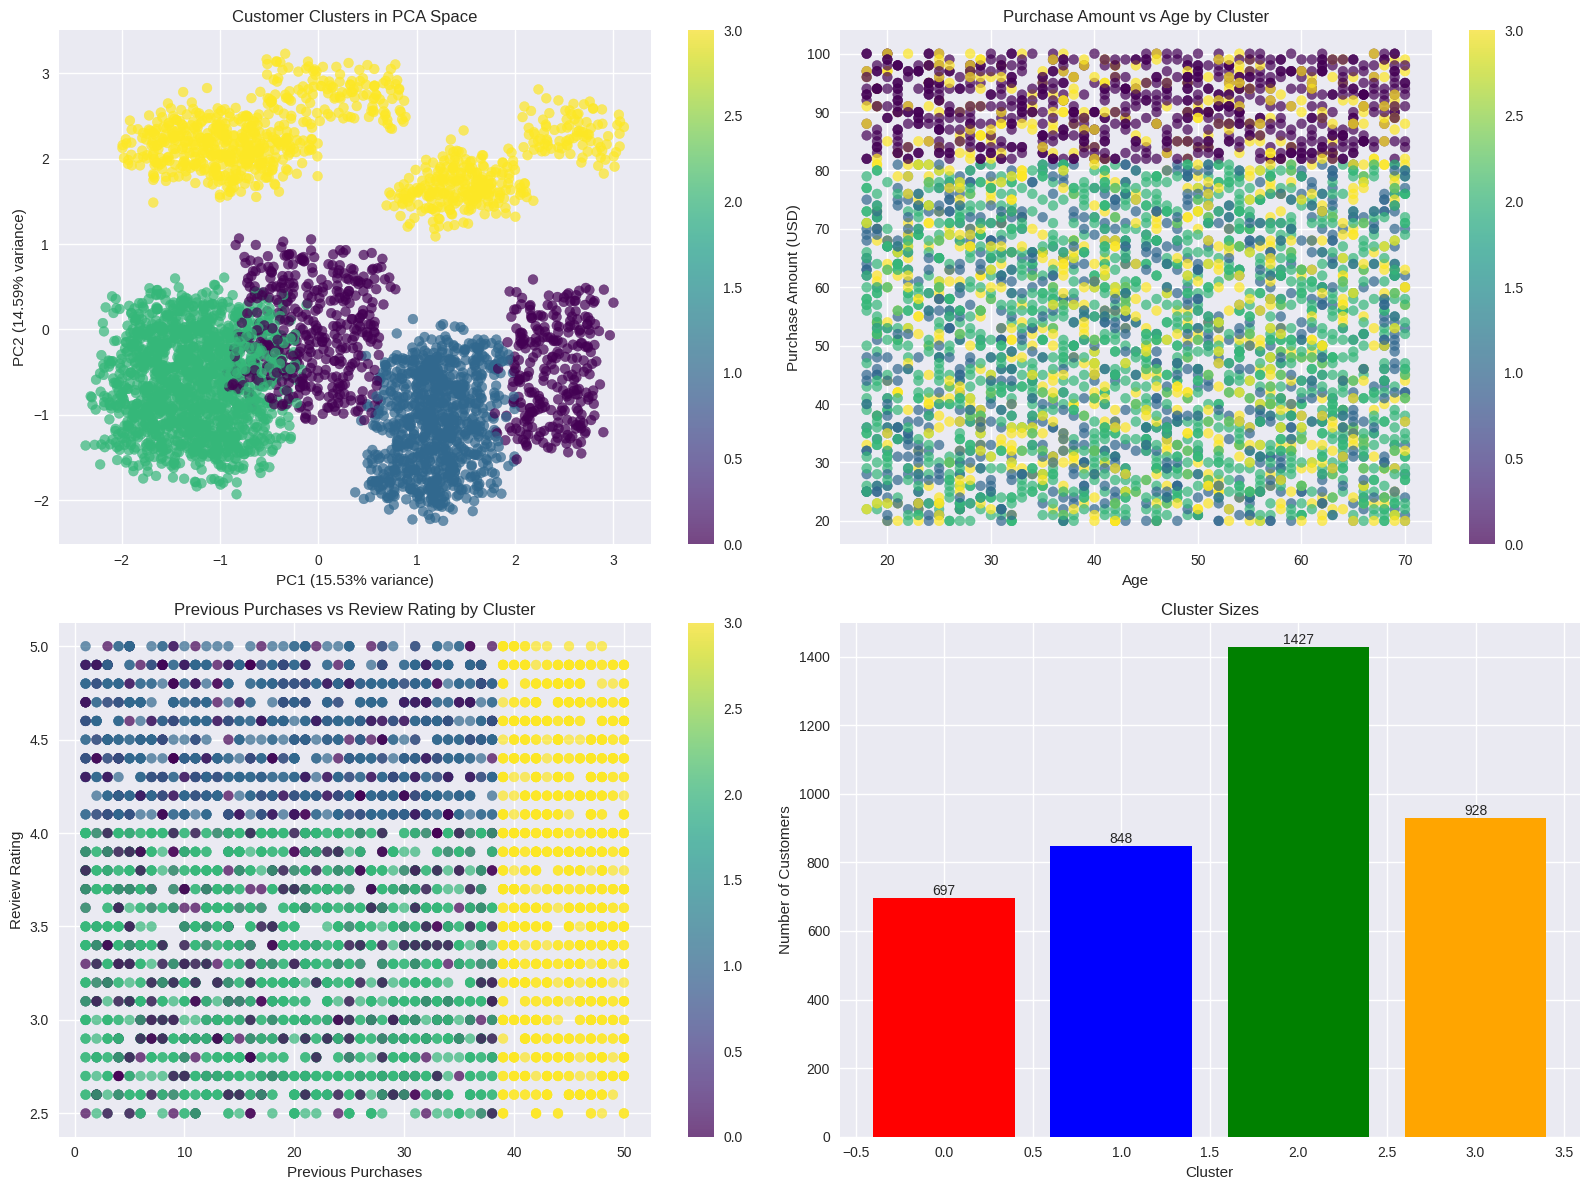

In [13]:
print("\n5. CLUSTER VISUALIZATION")
print("-" * 30)

# PCA for dimensionality reduction and 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization dataframe
viz_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
viz_df['Cluster'] = clusters
viz_df['Purchase_Amount'] = df['Purchase Amount (USD)']
viz_df['Age'] = df['Age']
viz_df['Previous_Purchases'] = df['Previous Purchases']

# Plot clusters in 2D
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Clusters in PCA space
scatter = axes[0,0].scatter(viz_df['PC1'], viz_df['PC2'], c=viz_df['Cluster'],
                           cmap='viridis', alpha=0.7, s=50)
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0,0].set_title('Customer Clusters in PCA Space')
plt.colorbar(scatter, ax=axes[0,0])

# Plot 2: Purchase Amount vs Age colored by cluster
scatter = axes[0,1].scatter(df['Age'], df['Purchase Amount (USD)'], c=clusters,
                           cmap='viridis', alpha=0.7, s=50)
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Purchase Amount (USD)')
axes[0,1].set_title('Purchase Amount vs Age by Cluster')
plt.colorbar(scatter, ax=axes[0,1])

# Plot 3: Previous Purchases vs Review Rating
scatter = axes[1,0].scatter(df['Previous Purchases'], df['Review Rating'], c=clusters,
                           cmap='viridis', alpha=0.7, s=50)
axes[1,0].set_xlabel('Previous Purchases')
axes[1,0].set_ylabel('Review Rating')
axes[1,0].set_title('Previous Purchases vs Review Rating by Cluster')
plt.colorbar(scatter, ax=axes[1,0])

# Plot 4: Cluster sizes
cluster_sizes = df['Cluster'].value_counts().sort_index()
axes[1,1].bar(cluster_sizes.index, cluster_sizes.values, color=['red', 'blue', 'green', 'orange'][:optimal_k])
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_title('Cluster Sizes')
for i, v in enumerate(cluster_sizes.values):
    axes[1,1].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [15]:
print("\n6. DETAILED CLUSTER ANALYSIS")
print("-" * 30)

# Analyze each cluster in detail
for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]

    print(f"\n--- CLUSTER {cluster_id} (n={len(cluster_data)}) ---")
    print(f"Demographics:")
    print(f"  • Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"  • Gender Distribution: {cluster_data['Gender'].value_counts().to_dict()}")

    print(f"Spending Behavior:")
    print(f"  • Avg Purchase Amount: ${cluster_data['Purchase Amount (USD)'].mean():.2f}")
    print(f"  • Total Spending: ${cluster_data['Purchase Amount (USD)'].sum():.2f}")
    print(f"  • Avg Previous Purchases: {cluster_data['Previous Purchases'].mean():.1f}")

    print(f"Preferences:")
    print(f"  • Top Category: {cluster_data['Category'].mode()[0]}")
    print(f"  • Top Season: {cluster_data['Season'].mode()[0]}")
    print(f"  • Avg Review Rating: {cluster_data['Review Rating'].mean():.2f}")

    print(f"Behavioral Patterns:")
    print(f"  • Common Payment: {cluster_data['Payment Method'].mode()[0]}")
    print(f"  • Common Frequency: {cluster_data['Frequency of Purchases'].mode()[0]}")
    print(f"  • Subscription Rate: {(cluster_data['Subscription Status'] == 'Yes').mean()*100:.1f}%")


6. DETAILED CLUSTER ANALYSIS
------------------------------

--- CLUSTER 0 (n=697) ---
Demographics:
  • Average Age: 43.9 years
  • Gender Distribution: {'Male': 466, 'Female': 231}
Spending Behavior:
  • Avg Purchase Amount: $91.07
  • Total Spending: $63478.00
  • Avg Previous Purchases: 19.1
Preferences:
  • Top Category: Clothing
  • Top Season: Fall
  • Avg Review Rating: 3.77
Behavioral Patterns:
  • Common Payment: Debit Card
  • Common Frequency: Annually
  • Subscription Rate: 25.5%

--- CLUSTER 1 (n=848) ---
Demographics:
  • Average Age: 43.4 years
  • Gender Distribution: {'Male': 583, 'Female': 265}
Spending Behavior:
  • Avg Purchase Amount: $50.45
  • Total Spending: $42781.00
  • Avg Previous Purchases: 19.5
Preferences:
  • Top Category: Clothing
  • Top Season: Spring
  • Avg Review Rating: 4.52
Behavioral Patterns:
  • Common Payment: Cash
  • Common Frequency: Every 3 Months
  • Subscription Rate: 27.5%

--- CLUSTER 2 (n=1427) ---
Demographics:
  • Average Age: 44

In [16]:
print("\n7. CLUSTER INTERPRETATION AND NAMING")
print("-" * 30)

cluster_names = {}
for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]

    # Define characteristics
    avg_age = cluster_data['Age'].mean()
    avg_spend = cluster_data['Purchase Amount (USD)'].mean()
    avg_prev_purchases = cluster_data['Previous Purchases'].mean()
    avg_rating = cluster_data['Review Rating'].mean()

    # Determine cluster type based on characteristics
    if avg_spend > df['Purchase Amount (USD)'].mean() and avg_prev_purchases > df['Previous Purchases'].mean():
        cluster_type = "High-Value Loyal Customers"
    elif avg_spend > df['Purchase Amount (USD)'].mean() and avg_prev_purchases <= df['Previous Purchases'].mean():
        cluster_type = "High-Spend Occasional Shoppers"
    elif avg_spend <= df['Purchase Amount (USD)'].mean() and avg_prev_purchases > df['Previous Purchases'].mean():
        cluster_type = "Frequent Budget Shoppers"
    else:
        cluster_type = "Occasional Budget Shoppers"

    # Age-based refinement
    if avg_age > 50:
        cluster_type += " (Mature)"
    elif avg_age < 30:
        cluster_type += " (Young)"
    else:
        cluster_type += " (Middle-aged)"

    cluster_names[cluster_id] = cluster_type
    print(f"Cluster {cluster_id}: {cluster_type}")

# Add cluster names to dataframe
df['Cluster_Name'] = df['Cluster'].map(cluster_names)


7. CLUSTER INTERPRETATION AND NAMING
------------------------------
Cluster 0: High-Spend Occasional Shoppers (Middle-aged)
Cluster 1: Occasional Budget Shoppers (Middle-aged)
Cluster 2: Occasional Budget Shoppers (Middle-aged)
Cluster 3: High-Value Loyal Customers (Middle-aged)


In [17]:
print("\n8. COMPARING CLUSTERING ALGORITHMS")
print("-" * 30)

# Try different clustering algorithms
algorithms = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=optimal_k),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

results = []

for name, algorithm in algorithms.items():
    if name == 'DBSCAN':
        labels = algorithm.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    else:
        labels = algorithm.fit_predict(X_scaled)
        n_clusters = optimal_k

    if n_clusters > 1:  # Only calculate metrics if we have more than 1 cluster
        silhouette = silhouette_score(X_scaled, labels)
        calinski = calinski_harabasz_score(X_scaled, labels)
        davies = davies_bouldin_score(X_scaled, labels)
    else:
        silhouette = calinski = davies = np.nan

    results.append({
        'Algorithm': name,
        'Number of Clusters': n_clusters,
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski,
        'Davies-Bouldin Score': davies
    })

results_df = pd.DataFrame(results)
print("Clustering Algorithms Comparison:")
print(results_df.round(3))


8. COMPARING CLUSTERING ALGORITHMS
------------------------------
Clustering Algorithms Comparison:
       Algorithm  Number of Clusters  Silhouette Score  \
0        K-Means                   4             0.155   
1  Agglomerative                   4             0.155   
2         DBSCAN                   0               NaN   

   Calinski-Harabasz Score  Davies-Bouldin Score  
0                  581.384                 1.904  
1                  581.384                 1.904  
2                      NaN                   NaN  


In [18]:
print("\n9. BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("-" * 30)

print("\nKEY INSIGHTS FROM CUSTOMER CLUSTERING:")

# Calculate overall metrics for comparison
overall_avg_spend = df['Purchase Amount (USD)'].mean()
overall_avg_prev = df['Previous Purchases'].mean()

for cluster_id, cluster_name in cluster_names.items():
    cluster_data = df[df['Cluster'] == cluster_id]

    print(f"\n📊 {cluster_name}:")
    print(f"   • Size: {len(cluster_data)} customers ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"   • Average Spend: ${cluster_data['Purchase Amount (USD)'].mean():.2f} "
          f"({'+' if cluster_data['Purchase Amount (USD)'].mean() > overall_avg_spend else ''}"
          f"{(cluster_data['Purchase Amount (USD)'].mean() - overall_avg_spend)/overall_avg_spend*100:.1f}% vs average)")
    print(f"   • Loyalty Level: {cluster_data['Previous Purchases'].mean():.1f} previous purchases")

    # Recommendations
    if "High-Value" in cluster_name:
        print(f"   💡 Recommendations: Premium loyalty programs, early access to new products, personalized service")
    elif "Frequent" in cluster_name:
        print(f"   💡 Recommendations: Volume discounts, subscription benefits, referral programs")
    elif "High-Spend" in cluster_name:
        print(f"   💡 Recommendations: Luxury product recommendations, exclusive events, premium support")
    else:
        print(f"   💡 Recommendations: Entry-level offers, educational content, budget-friendly options")


9. BUSINESS INSIGHTS AND RECOMMENDATIONS
------------------------------

KEY INSIGHTS FROM CUSTOMER CLUSTERING:

📊 High-Spend Occasional Shoppers (Middle-aged):
   • Size: 697 customers (17.9%)
   • Average Spend: $91.07 (+52.4% vs average)
   • Loyalty Level: 19.1 previous purchases
   💡 Recommendations: Luxury product recommendations, exclusive events, premium support

📊 Occasional Budget Shoppers (Middle-aged):
   • Size: 848 customers (21.7%)
   • Average Spend: $50.45 (-15.6% vs average)
   • Loyalty Level: 19.5 previous purchases
   💡 Recommendations: Entry-level offers, educational content, budget-friendly options

📊 Occasional Budget Shoppers (Middle-aged):
   • Size: 1427 customers (36.6%)
   • Average Spend: $49.87 (-16.6% vs average)
   • Loyalty Level: 19.4 previous purchases
   💡 Recommendations: Entry-level offers, educational content, budget-friendly options

📊 High-Value Loyal Customers (Middle-aged):
   • Size: 928 customers (23.8%)
   • Average Spend: $59.98 (+0.4% v

In [19]:
print("\n10. SAVING RESULTS")
print("-" * 30)

# Save clustered data
output_file = 'customer_clusters_analysis.csv'
df.to_csv(output_file, index=False)

# Save cluster profiles
cluster_summary = df.groupby(['Cluster', 'Cluster_Name']).agg({
    'Age': 'mean',
    'Purchase Amount (USD)': ['mean', 'sum'],
    'Previous Purchases': 'mean',
    'Review Rating': 'mean',
    'Customer ID': 'count',
    'Subscription Status': lambda x: (x == 'Yes').mean()
}).round(2)

cluster_summary.columns = ['Avg_Age', 'Avg_Spend', 'Total_Spend', 'Avg_Previous_Purchases',
                          'Avg_Rating', 'Customer_Count', 'Subscription_Rate']
cluster_summary.to_csv('cluster_profiles_summary.csv')

print(f"Clustered data saved to: {output_file}")
print(f"Cluster profiles saved to: cluster_profiles_summary.csv")

print("\n" + "="*50)
print("CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"\nTotal customers analyzed: {len(df)}")
print(f"Number of clusters identified: {optimal_k}")
print(f"Best clustering algorithm: K-Means")
print(f"Average silhouette score: {silhouette_score(X_scaled, clusters):.3f}")


10. SAVING RESULTS
------------------------------
Clustered data saved to: customer_clusters_analysis.csv
Cluster profiles saved to: cluster_profiles_summary.csv

CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY!

Total customers analyzed: 3900
Number of clusters identified: 4
Best clustering algorithm: K-Means
Average silhouette score: 0.155
